## Hyperparameter Tuning for Transmission Losses

Supervised ML algorithms: `ElasticNet`

Hyperparameter tuning framework: `Optuna`

In [2]:
import optuna
from optuna.integration.tensorboard import TensorBoardCallback
from optuna.trial import TrialState

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import config_context

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
from plotnine import *
from mizani.formatters import comma_format, percent_format, currency_format
from datetime import datetime, timedelta, date
from tqdm.notebook import tqdm
from skimpy import clean_columns
from IPython.display import clear_output, display
import holidays
from pickle import dump, load
import warnings

pd.set_option("display.max.columns", 50)

%load_ext blackcellmagic

### Reading in the Preprocessed Data and Making Base Splits

In [5]:
df = pd.read_csv("df_base_trainval_preprocessed.csv", parse_dates=["Zeitstempel"])

In [6]:
X, y = df.drop(["Zeitstempel", "MWh"], axis=1), df["MWh"]

In [8]:
preprocessor = load(open('sklearn_base_pipeline_unfitted.pickle', 'rb'))

In [9]:
tscv = TimeSeriesSplit(n_splits=5)

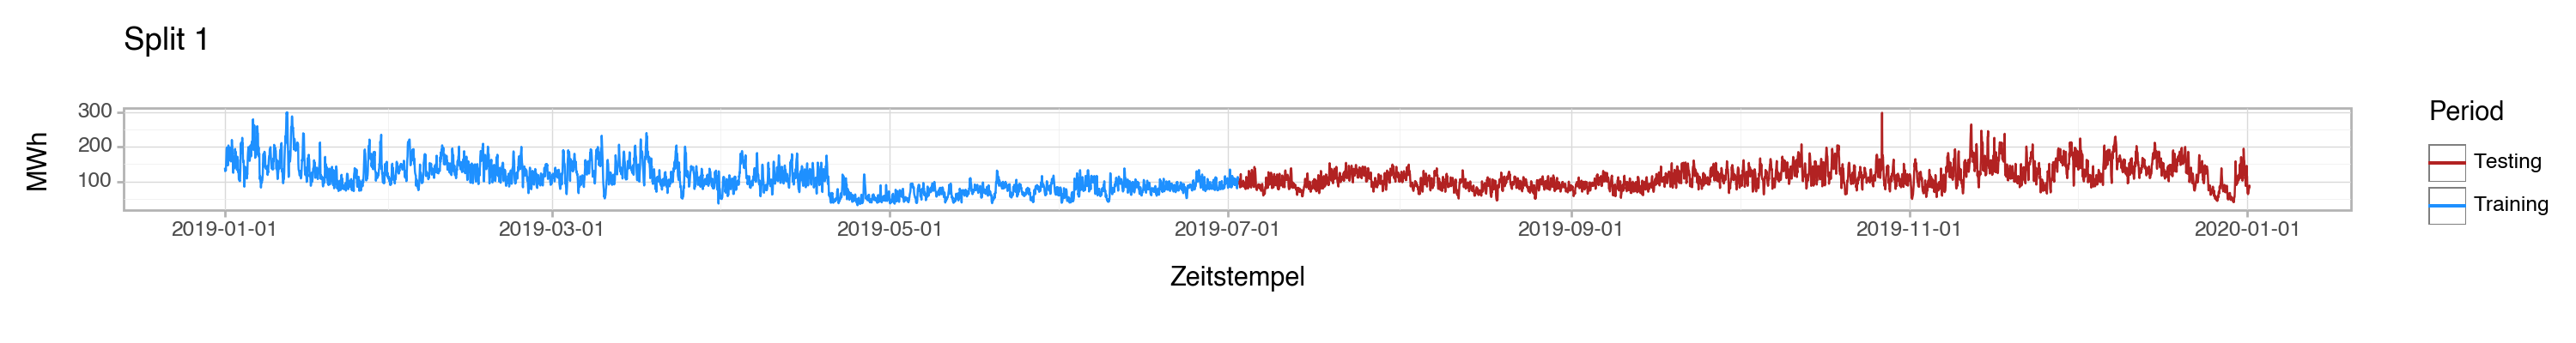

<Figure Size: (1500 x 200)>

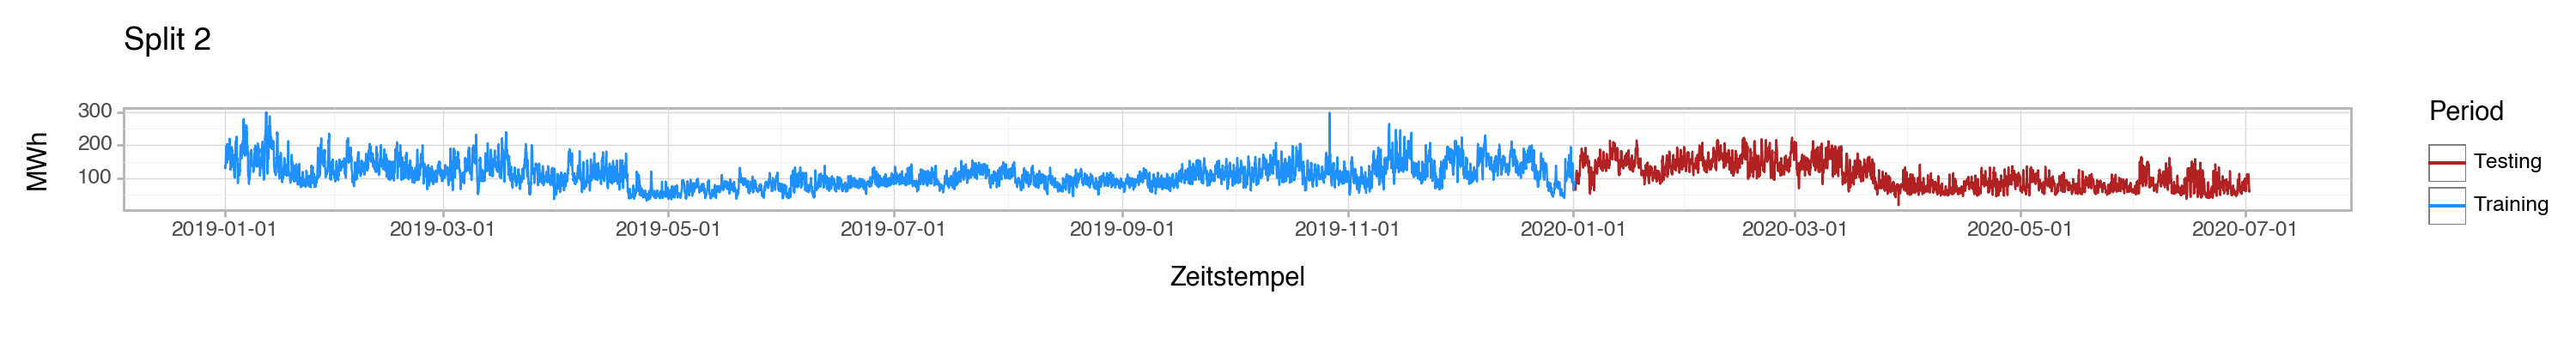

<Figure Size: (1500 x 200)>

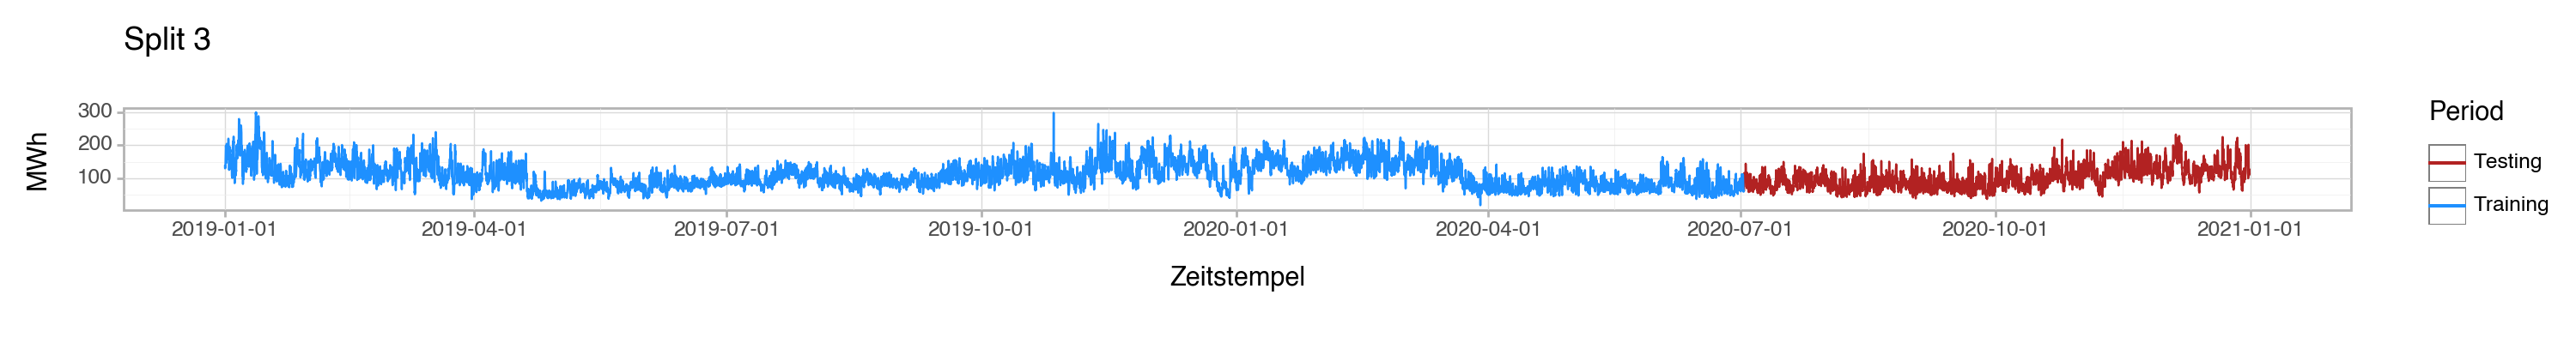

<Figure Size: (1500 x 200)>

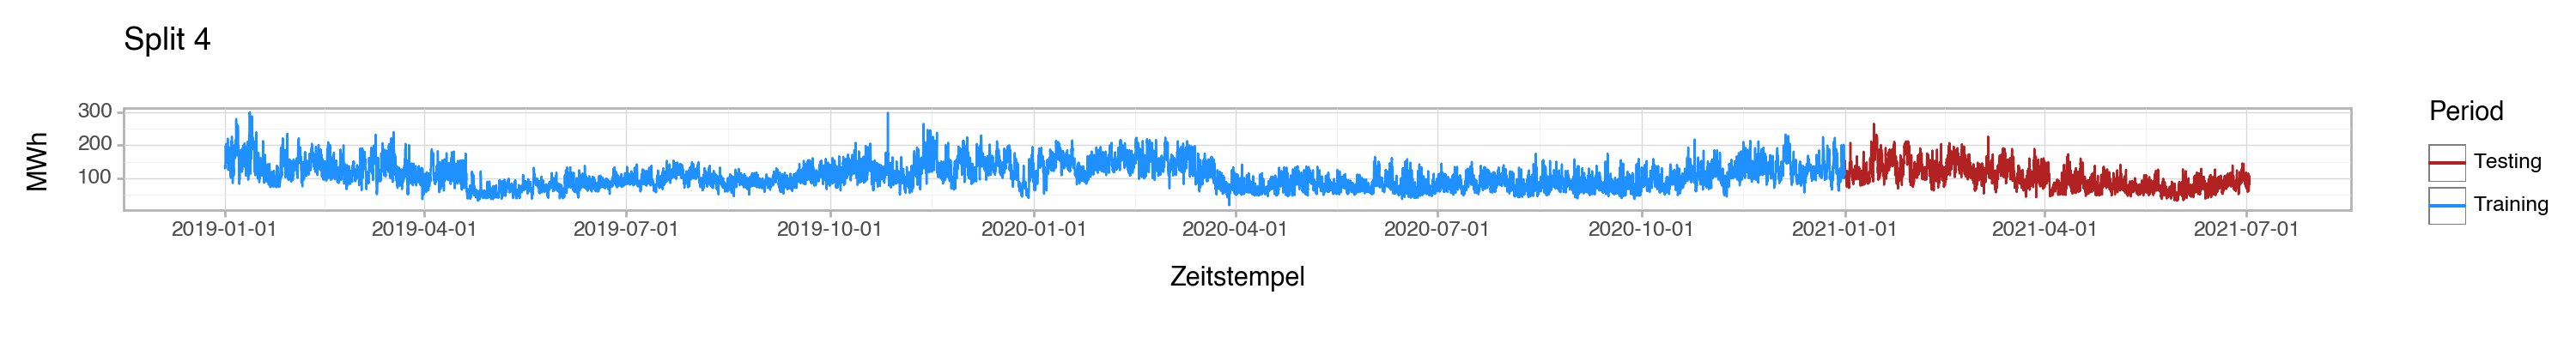

<Figure Size: (1500 x 200)>

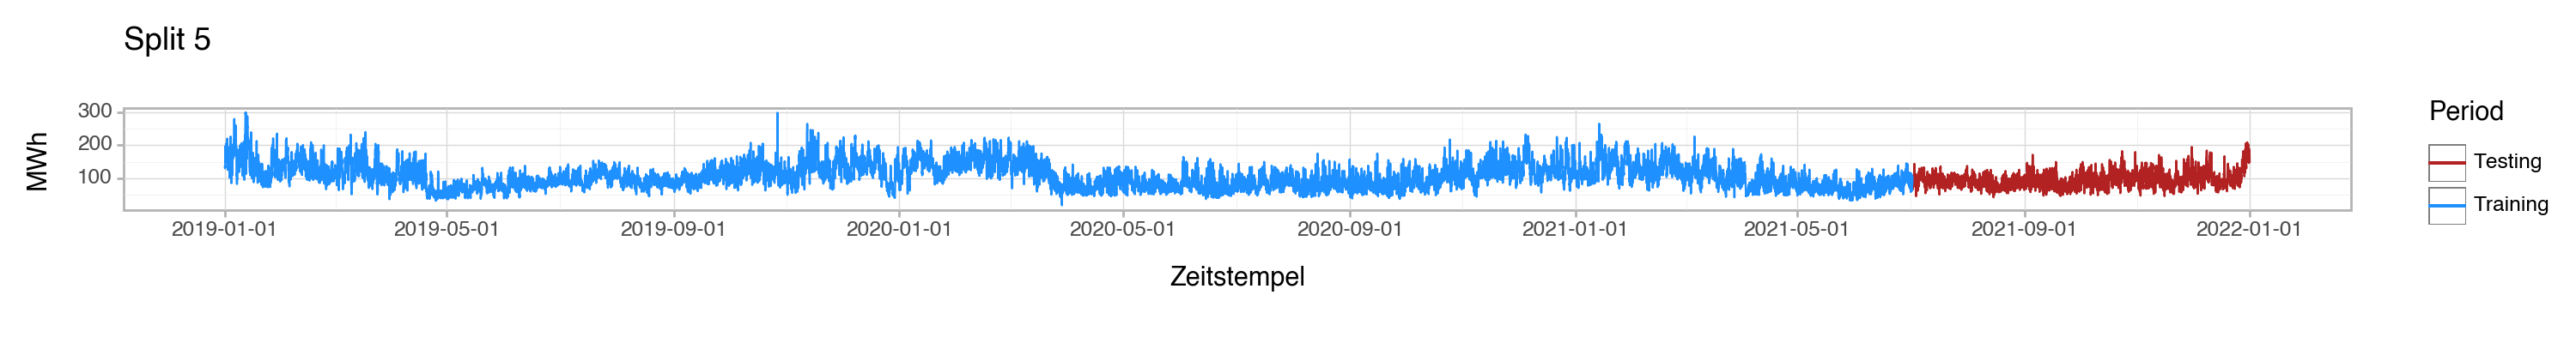

<Figure Size: (1500 x 200)>

In [10]:
# Iterate through the splits
for split_idx, (train_index, test_index) in enumerate(tscv.split(X)):
    train_dates = df["Zeitstempel"].iloc[train_index]
    test_dates = df["Zeitstempel"].iloc[test_index]

    y_train, y_test = pd.DataFrame(
        {
            "Zeitstempel": train_dates.reset_index(drop=True),
            "MWh": y.iloc[train_index].reset_index(drop=True),
            "Period": "Training",
        }
    ), pd.DataFrame(
        {
            "Zeitstempel": test_dates.reset_index(drop=True),
            "MWh": y.iloc[test_index].reset_index(drop=True),
            "Period": "Testing",
        }
    )

    with warnings.catch_warnings():  # sanest pandas user
        warnings.simplefilter("ignore")

        p = (
            ggplot(
                data=pd.concat([y_train, y_test], axis=0),
                mapping=aes(x="Zeitstempel", y="MWh", colour="Period"),
            )
            + labs(title=f"Split {split_idx + 1}")
            + geom_line()
            + scale_colour_manual(values=["firebrick", "dodgerblue"])
            + theme_light()
            + theme(figure_size=[15, 2])
        )
        display(p)

### Training and Tuning with ElasticNet and Optuna

In [11]:
with warnings.catch_warnings():  # sanest pandas user
    warnings.simplefilter("ignore")

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index].reset_index(drop=True), X.iloc[test_index].reset_index(drop=True)
        y_train, y_test = y.iloc[train_index].reset_index(drop=True), y.iloc[test_index].reset_index(drop=True)
        
        # Fit preprocessor on each training split
        fitted_preprocessor = preprocessor.fit(X_train)
        
        X_train = pd.DataFrame(
            fitted_preprocessor.transform(X_train),
            columns=fitted_preprocessor.get_feature_names_out(),
        )

        X_test = pd.DataFrame(
            fitted_preprocessor.transform(X_test),
            columns=fitted_preprocessor.get_feature_names_out(),
        )

        break

In [12]:
X_train

,numeric__temperature_fore_ch,numeric__temperature_fore_fr,numeric__temperature_fore_de,numeric__temperature_fore_it,numeric__solar_fore_de_mw,numeric__solar_fore_it_mw,numeric__wind_fore_de_mw,numeric__wind_fore_it_mw,numeric__CH_AT,numeric__CH_DE,numeric__CH_FR,numeric__CH_IT,numeric__AT_CH,numeric__DE_CH,numeric__FR_CH,numeric__IT_CH,numeric__year,numeric__hour_counter,numeric__hour_sin,numeric__hour_cos,numeric__week_hour_sin,numeric__week_hour_cos,numeric__month_sin,numeric__month_cos,numeric__quarter_sin,...,numeric__target_lag_152,numeric__target_lag_153,numeric__target_lag_154,numeric__target_lag_155,numeric__target_lag_156,numeric__target_lag_157,numeric__target_lag_158,numeric__target_lag_159,numeric__target_lag_160,numeric__target_lag_161,numeric__target_lag_162,numeric__target_lag_163,numeric__target_lag_164,numeric__target_lag_165,numeric__target_lag_166,numeric__target_lag_167,categorical__weekend_0,categorical__weekend_1,categorical__work_hour_0,categorical__work_hour_1,categorical__holiday_name_Auffahrt,categorical__holiday_name_Neujahrestag,categorical__holiday_name_Ostern,categorical__holiday_name_Pfingsten,categorical__holiday_name_none
0,-0.685388,-0.891008,-0.331776,-1.174644,-0.703026,-0.763611,0.746805,1.273010,0.444964,0.445439,0.088378,0.471834,0.875518,-1.235905,0.739629,0.976563,0.0,-1.731656,0.365682,1.367307,1.129421,0.839651,-0.307883,1.517845,0.996782,...,0.000000,0.00000,0.00000,0.000000,-4.230669e-16,0.000000,4.126091e-16,4.137891e-16,0.0000,0.000000,5.162912e-16,-4.963203e-16,-4.448504e-16,3.982893e-16,0.000000,-3.198850e-16,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.685388,-0.891008,-0.331776,-1.174644,-0.703026,-0.763611,0.921293,1.469920,0.444964,0.445439,0.088378,0.471834,0.875518,-1.235905,0.739629,0.976563,0.0,-1.730867,0.706672,1.225988,1.159970,0.796437,-0.307883,1.517845,0.996782,...,0.000000,0.00000,0.00000,0.000000,-4.230669e-16,0.000000,4.126091e-16,4.137891e-16,0.0000,0.000000,5.162912e-16,-4.963203e-16,-4.448504e-16,3.982893e-16,0.000000,-3.198850e-16,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.685388,-0.891008,-0.331776,-1.174644,-0.703026,-0.763611,1.117258,1.390836,0.444964,0.445439,0.088378,0.471834,0.875518,-1.235905,0.739629,0.976563,0.0,-1.730078,0.999486,1.001183,1.188887,0.752106,-0.307883,1.517845,0.996782,...,0.000000,0.00000,0.00000,0.000000,-4.230669e-16,0.000000,4.126091e-16,4.137891e-16,0.0000,0.000000,5.162912e-16,-4.963203e-16,-4.448504e-16,3.982893e-16,0.000000,-3.198850e-16,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.685388,-0.891008,-0.331776,-1.174644,-0.703026,-0.763611,1.333185,1.286862,0.444964,0.445439,0.088378,0.471834,0.875518,-1.235905,0.739629,0.976563,0.0,-1.729288,1.224170,0.708210,1.216133,0.706721,-0.307883,1.517845,0.996782,...,0.000000,0.00000,0.00000,0.000000,-4.230669e-16,0.000000,4.126091e-16,4.137891e-16,0.0000,0.000000,5.162912e-16,-4.963203e-16,-4.448504e-16,3.982893e-16,0.000000,-3.198850e-16,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.685388,-0.891008,-0.331776,-1.174644,-0.703026,-0.763611,1.313565,1.225528,0.444964,0.445439,0.088378,0.471834,0.875518,-1.235905,0.739629,0.976563,0.0,-1.728499,1.365413,0.367037,1.241669,0.660345,-0.307883,1.517845,0.996782,...,0.000000,0.00000,0.00000,0.000000,-4.230669e-16,0.000000,4.126091e-16,4.137891e-16,0.0000,0.000000,5.162912e-16,-4.963203e-16,-4.448504e-16,3.982893e-16,0.000000,-3.198850e-16,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4384,2.394984,2.182310,1.498277,2.482488,1.566161,1.421591,0.305445,-0.903369,-0.059428,-2.019028,0.088378,-0.091431,-0.348954,-1.235905,-1.788894,-1.807661,0.0,1.728499,-1.365902,-0.365212,1.404266,0.051268,-3.143728,-0.999328,-2.850954,...,0.362631,0.87224,0.85525,0.245575,-1.369598e-01,-0.500017,-1.858879e-01,-2.796760e-01,-0.5301,-0.318035,5.488929e-01,6.742775e-01,4.043594e-0

Looks good, let's get crackin:

In [14]:
def objective(trial):
          
    params = {
        'alpha': trial.suggest_float('alpha', 0, 100),
        'l1_ratio': trial.suggest_float('l1_ratio', 0, 1),
        'max_iter': trial.suggest_int('max_iter', 500, 5000)
    }

    mae_cv_list = []

    with warnings.catch_warnings(): # sanest pandas user
        warnings.simplefilter("ignore")

        # Iterate through the splits
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index].reset_index(drop=True), X.iloc[test_index].reset_index(drop=True)
            y_train, y_test = y.iloc[train_index].reset_index(drop=True), y.iloc[test_index].reset_index(drop=True)
            
            # Fit preprocessor on each training split
            fitted_preprocessor = preprocessor.fit(X_train)
            
            X_train = pd.DataFrame(
                fitted_preprocessor.transform(X_train),
                columns=fitted_preprocessor.get_feature_names_out(),
            )

            X_test = pd.DataFrame(
                fitted_preprocessor.transform(X_test),
                columns=fitted_preprocessor.get_feature_names_out(),
            )

            # Example using a hypothetical model (replace with your actual model):
            model = ElasticNet(**params)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Calculate evaluation metrics (e.g., MSE, MAE, etc.) for each fold
            # Example using mean squared error (MSE):
            mae_cv_list.append(mean_absolute_error(y_test, y_pred))
            
    return np.mean(mae_cv_list)

study = optuna.create_study(direction='minimize')
# changed here too 20 
study.optimize(objective, n_trials=20, timeout=3600*0.5)

[I 2023-11-10 19:15:48,095] A new study created in memory with name: no-name-3c70b94a-a42a-4ffd-b728-b14d21d24a96
[I 2023-11-10 19:15:50,150] Trial 0 finished with value: 28.395129319069135 and parameters: {'alpha': 92.91636426800135, 'l1_ratio': 0.6202056822278195, 'max_iter': 653}. Best is trial 0 with value: 28.395129319069135.
[I 2023-11-10 19:15:52,199] Trial 1 finished with value: 21.580940719393517 and parameters: {'alpha': 10.779819737220532, 'l1_ratio': 0.8481368500291118, 'max_iter': 1293}. Best is trial 1 with value: 21.580940719393517.
[I 2023-11-10 19:15:54,607] Trial 2 finished with value: 18.7776699079519 and parameters: {'alpha': 0.703030283796191, 'l1_ratio': 0.3444762107231616, 'max_iter': 4318}. Best is trial 2 with value: 18.7776699079519.
[I 2023-11-10 19:15:56,977] Trial 3 finished with value: 20.839567492884896 and parameters: {'alpha': 16.686345997537146, 'l1_ratio': 0.14308583309992595, 'max_iter': 1268}. Best is trial 2 with value: 18.7776699079519.
[I 2023-11

In [15]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# Display the study statistics
print("\nStudy statistics: ")
print(f"  Number of finished trials: {len(study.trials)}")
print(f"  Number of pruned trials: {len(pruned_trials)}")
print(f"  Number of complete trials: {len(complete_trials)}")


Study statistics: 
  Number of finished trials: 20
  Number of pruned trials: 0
  Number of complete trials: 20


In [16]:
study.best_params

{'alpha': 0.703030283796191, 'l1_ratio': 0.3444762107231616, 'max_iter': 4318}

In [19]:
study.trials_dataframe().to_csv("en_tuning_optuna.csv", index=False)

In [20]:
study.best_value

18.7776699079519

In [21]:
study.best_params

{'alpha': 0.703030283796191, 'l1_ratio': 0.3444762107231616, 'max_iter': 4318}

In [22]:
with open("EN_hyperparams.pickle", 'wb') as file:
    dump(study.best_params, file)

### Training Best Model on Training + Validation Data

The best hyperparameters for this model are already known, so let's train the best model on the training AND validation data, in order to make predictions on the test dataset, which are then used to make predictions with by the meta model.

Here, I need to refit the sklearn pipeline to the entire dataset in order to make the training consistent.

In [24]:
# Read in best hyperparameter combination from tuning
with open("EN_hyperparams.pickle", 'rb') as file:
    best_config = load(file)

In [25]:
preprocessor = load(open('sklearn_base_pipeline_unfitted.pickle', 'rb'))

In [26]:
df = pd.read_csv("df_base_trainval_preprocessed.csv")

X_train_final = (
    df
    .drop(["Zeitstempel", "MWh"], axis=1)
    .reset_index(drop=True)
)
y_train_final = df["MWh"].reset_index(
    drop=True
)

In [27]:
fitted_preprocessor = preprocessor.fit(X_train_final)

In [28]:
X_train_final = pd.DataFrame(
    fitted_preprocessor.transform(X_train_final),
    columns=fitted_preprocessor.get_feature_names_out(),
)

In [29]:
model = ElasticNet(**best_config)
model.fit(X_train_final, y_train_final)

ElasticNet(alpha=0.703030283796191, l1_ratio=0.3444762107231616, max_iter=4318)

In [30]:
# write Elastic Net Model to pickle
with open("en_trainval.pickle", 'wb') as file:
    dump(model, file)